In [1]:
import webbrowser
import pyautogui, sys
import time
import tensorflow as tf
import mss
import mss.tools
from PIL import Image
import os
import numpy as np
from matplotlib import pyplot as plt

#mouse control and window dimensions
SCREEN_WIDTH = 1920
SCREEN_HEIGHT = 1080
MONITOR_WIDTH = 800
MONITOR_HEIGHT = 600
X_OFFSET = 80
Y_OFFSET = 100
IMAGE_SIZE = (12, 8)

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

## Cargar Modelo

In [2]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = 'frozen_inference_graph.pb'
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('training', 'object-detection.pbtxt')
# Number of classes in the pbtxt file that can be detected by the model
NUM_CLASSES = 1

detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading Label Map

In [3]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Helper Code

In [26]:
def move_left():
    pyautogui.press('left')
    
def move_right():
    pyautogui.press('right')
    
def move_up():
    pyautogui.press('up')
    
def move_down():
    pyautogui.press('down')
    
def move_upleft():
    pyautogui.press(['left', 'up'])
    
def move_upright():
    pyautogui.press(['up', 'right'])
    
def move_downleft():
    pyautogui.press(['left', 'down'])
    
def move_downright():
    pyautogui.press(['down', 'right'])

def play_again():
    pyautogui.click(x=900, y=590)
    pyautogui.click(x=1000, y=610)
    

def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

## Deteccion

In [10]:
PATH_TO_TEST_IMAGES_DIR = 'annotations'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}.png'.format(i)) for i in range(710,721) ]
IMAGE_SIZE = (12, 8)

In [6]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

## Offline

## Main

In [27]:
url = 'http://surviv.io'
# Open URL in a new tab, if a browser window is already open.
webbrowser.open_new_tab(url)
#pyautogui.moveTo(1000, 610)   # moves mouse to X of 100, Y of 200.
time.sleep(2)
pyautogui.click(x=1000, y=610)
time.sleep(2)
monitor = {'top': Y_OFFSET, 'left': X_OFFSET, 'width': SCREEN_WIDTH-X_OFFSET, 'height': SCREEN_HEIGHT-Y_OFFSET}
n_screenshots = 0
count = 0
while True:
    with mss.mss() as sct:
        # Get raw pixels from the screen
        sct_img = sct.grab(monitor)
        # Create the Image
        img = Image.frombytes("RGB", sct_img.size, sct_img.bgra, "raw", "BGRX")
        # The same, but less efficient:
        # img = Image.frombytes('RGB', sct_img.size, sct_img.rgb)
        screen = np.array(img)
        #screen = cv2.resize(screen, (MONITOR_WIDTH, MONITOR_HEIGHT))
        image_np = screen
        image_np_expanded = np.expand_dims(image_np, axis=0)
        # Actual detection.
        output_dict = run_inference_for_single_image(image_np, detection_graph)

        # And save it!
        exists = os.path.isfile('./annotations/'+str(n_screenshots+1)+'.png')
        while exists:
            n_screenshots += 1
            exists = os.path.isfile('./annotations/'+str(n_screenshots+1)+'.png')
        output = "./test_raw/"+str(n_screenshots+1)+".png"
        img.save(output)
        # Visualization of the results of a detection.
        vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,
            output_dict['detection_boxes'],
            output_dict['detection_classes'],
            output_dict['detection_scores'],
            category_index,
            instance_masks=output_dict.get('detection_masks'),
            use_normalized_coordinates=True,
            line_thickness=8)
        im = Image.fromarray(image_np)
        im.save("./test/"+str(n_screenshots+1)+".png")
        print (str(n_screenshots+1)+'.png')
        n_screenshots += 1
        #time.sleep(5)
        playerHP = np.sum(image_np[945:948,710:1120])
        print("Player HP: " + str(playerHP))
        if playerHP==last_hp:
            count +=1
        else:
            count = 0
        if playerHP < 100000 and count==10:
            play_again()
        last_hp = playerHP
        #60000 umbral

25.png
Player HP: 643176
35.png
Player HP: 643176
38.png
Player HP: 643176
201.png
Player HP: 643176
202.png
Player HP: 643176
203.png
Player HP: 643176
204.png
Player HP: 643176
205.png
Player HP: 404565
206.png
Player HP: 258459
207.png
Player HP: 258459
208.png
Player HP: 258459
209.png
Player HP: 200052
210.png
Player HP: 64788
211.png
Player HP: 64788
212.png
Player HP: 64788
213.png
Player HP: 64788
214.png
Player HP: 64788
215.png
Player HP: 64788
216.png
Player HP: 64788
217.png
Player HP: 64788
218.png
Player HP: 64788
219.png
Player HP: 64788
220.png
Player HP: 64788
221.png
Player HP: 203132
222.png
Player HP: 246000
223.png
Player HP: 643980
224.png
Player HP: 643980
225.png
Player HP: 643980
226.png
Player HP: 643980
227.png
Player HP: 643980
228.png
Player HP: 643980
229.png
Player HP: 643980
230.png
Player HP: 643980
231.png
Player HP: 643980
232.png
Player HP: 643980
233.png
Player HP: 203132
234.png
Player HP: 835101


KeyboardInterrupt: 

398417
419172
412644
437301
207198
233752
233679
216875
59906
59906
59906


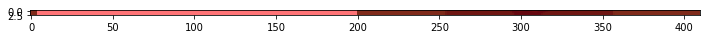

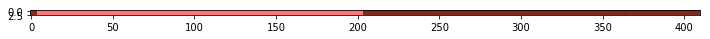

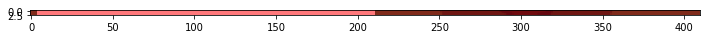

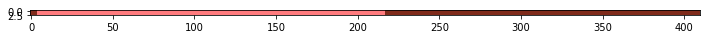

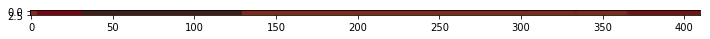

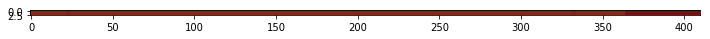

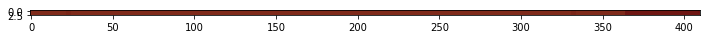

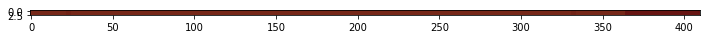

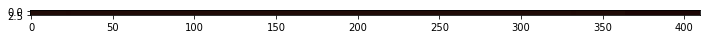

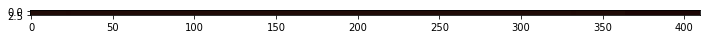

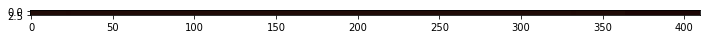

In [12]:
%matplotlib inline
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
    image_np = image_np[945:948,710:1120]
    print(np.sum(image_np))
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)


In [17]:
#pyautogui.click(x=900, y=590)
pyautogui.moveTo(900, 590)  